<a href="https://colab.research.google.com/github/AnnabelHall/QCES_LNM/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations.

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height.

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=0 $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation.

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [2]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1)
H.change_scales(1)
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+00/s


2024-11-22 19:17:16,133 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+00/s


INFO:__main__:Starting main loop


2024-11-22 19:17:16,143 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-22 19:17:16,560 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 100


2024-11-22 19:17:16,564 solvers 0/1 INFO :: Final iteration: 100


INFO:solvers:Final sim time: 6000.0


2024-11-22 19:17:16,568 solvers 0/1 INFO :: Final sim time: 6000.0


INFO:solvers:Setup time (init - iter 0): 0.4131 sec


2024-11-22 19:17:16,573 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4131 sec


INFO:solvers:Warmup time (iter 0-10): 0.0707 sec


2024-11-22 19:17:16,578 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0707 sec


INFO:solvers:Run time (iter 10-end): 0.345 sec


2024-11-22 19:17:16,583 solvers 0/1 INFO :: Run time (iter 10-end): 0.345 sec


INFO:solvers:CPU time (iter 10-end): 9.582e-05 cpu-hr


2024-11-22 19:17:16,592 solvers 0/1 INFO :: CPU time (iter 10-end): 9.582e-05 cpu-hr


INFO:solvers:Speed: 5.333e+05 mode-stages/cpu-sec


2024-11-22 19:17:16,598 solvers 0/1 INFO :: Speed: 5.333e+05 mode-stages/cpu-sec


### 1.2  Plotting
The code below will make a movie of the height.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-11-22 19:17:16,878 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp9wvfdp3p/temp.m4v


2024-11-22 19:17:16,890 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp9wvfdp3p/temp.m4v


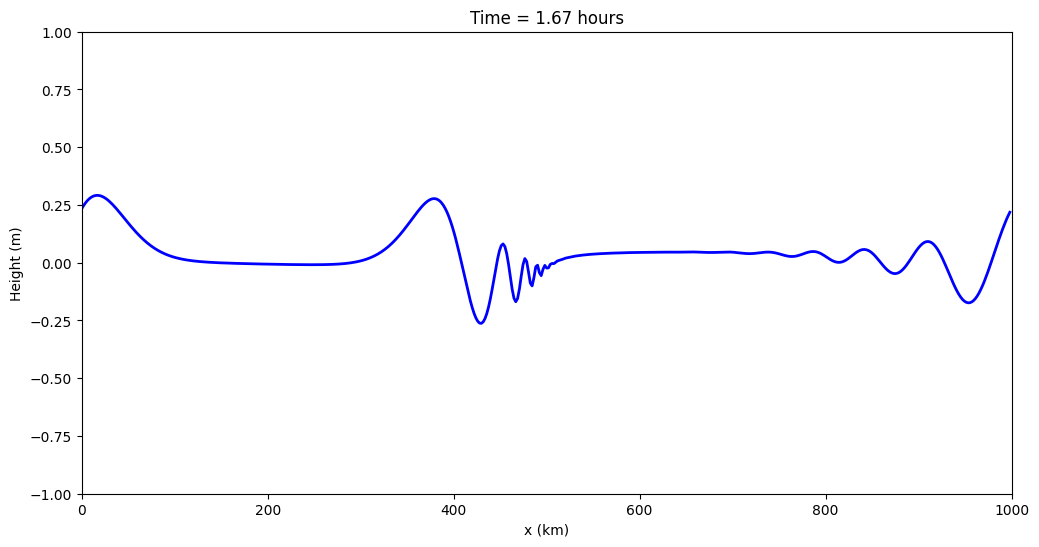

In [3]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value.

**My Answer**

We are initially given the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

However, we assume that $u, v, h$ are small. Therefore, multiples of these variables can be removed and we receive:

$$ \partial_t u + g \partial_x(h) = 0 $$
$$ \partial_t h + \partial_x(Hu) = 0 $$

This produces the following governing equation:

$$ \partial_{tt} h - gH \partial_{xx}u = 0 $$

We look for solutions of the form: $$ h = h_0 cos(kx-wt)$$ and hence by inspection $$w = \pm \sqrt{gH} k$$

Here, $H$ takes into account the varying bottom depth $h_b$ already, giving final phase velocity $$w/k = \pm \sqrt{gH}$$

Text(0.5, 0, 'x (m)')

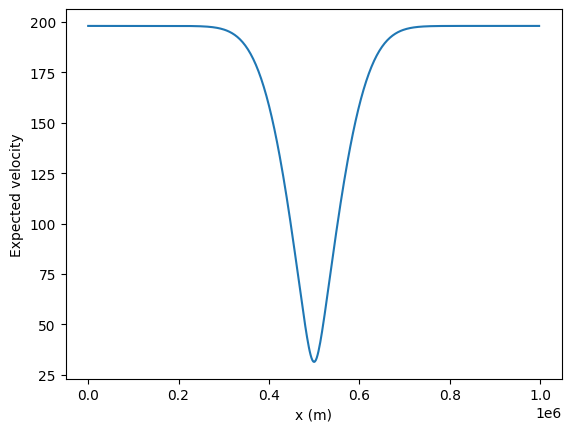

In [4]:
# Here is what our expected wave speed is as given by above

plt.plot(x, (g*H['g'])**0.5)
plt.ylabel('Expected velocity')
plt.xlabel('x (m)')

Text(0.5, 0, 'x (km)')

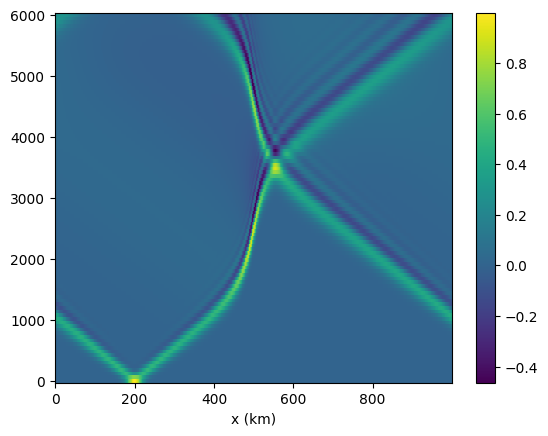

In [5]:
# the colour value of h gives the peaks and troughs
# This therefore shows wave propogation
# wave speed can be derived from the gradient x with t along the peaks
plt.pcolormesh(x/1000, t_save, h_save)
plt.colorbar()
plt.xlabel('x (km)')

Text(0, 0.5, 'wave velocity')

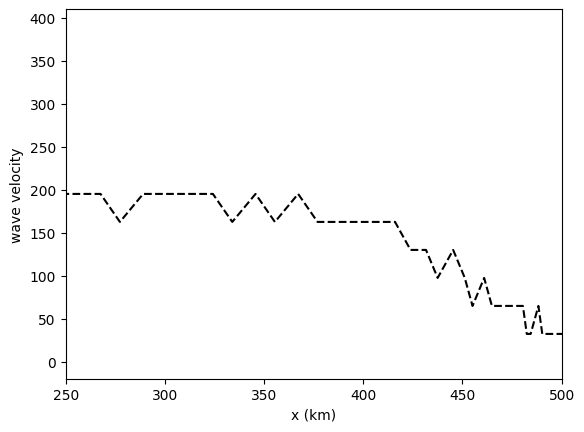

In [6]:
# This represents the greatest velocity points at each x value
# this is displayed between 250km and 500km

peak_x = x[np.argmax(h_save[:50,95:],axis=1)+95]
peak_u = np.zeros(50)
for i in range(1,50):
  peak_u[i] = (peak_x[i]-peak_x[i-1])/timestep
plt.plot(peak_x/1000,peak_u,'k--')

plt.xlim(250,500)
plt.xlabel('x (km)')
plt.ylabel('wave velocity')

Text(0.5, 1.0, 'Both predictions overlaid')

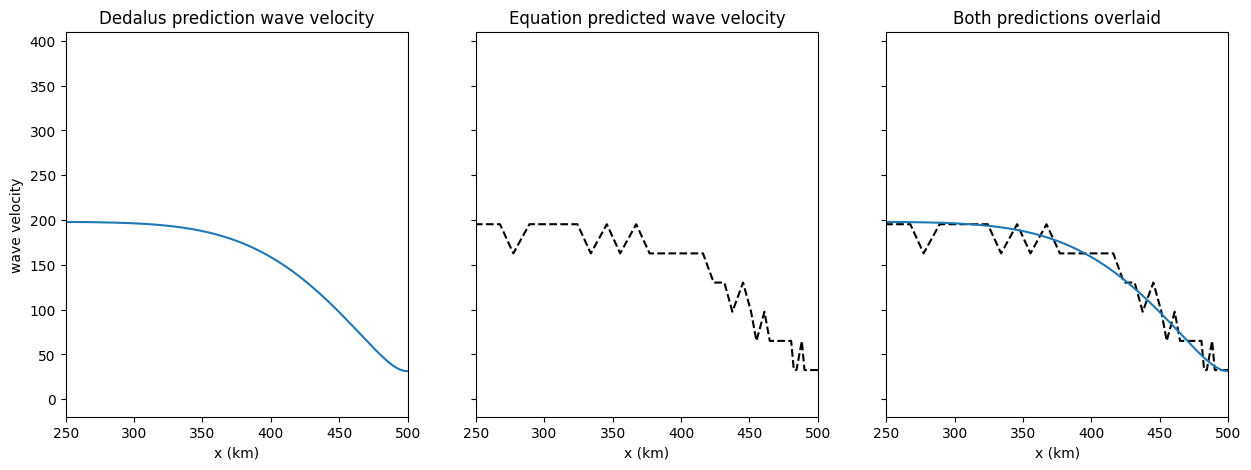

In [7]:
fig, axs = plt.subplots(figsize=(15,5), ncols = 3, sharey=True)

axs[0].plot(x/1000, (g*H['g'])**0.5)
# axs[0].ylabel('Expected velocity')
# axs[0].xlabel('x (m)')

axs[1].plot(peak_x/1000,peak_u,'k--')

axs[2].plot(peak_x/1000,peak_u,'k--')
axs[2].plot(x/1000, (g*H['g'])**0.5)

axs[0].set_xlim(250,500)
axs[1].set_xlim(250,500)
axs[2].set_xlim(250,500)

axs[0].set_ylabel('wave velocity')
axs[0].set_xlabel('x (km)')
axs[1].set_xlabel('x (km)')
axs[2].set_xlabel('x (km)')

axs[0].set_title('Dedalus prediction wave velocity')
axs[1].set_title('Equation predicted wave velocity')
axs[2].set_title('Both predictions overlaid')

**My Answer**

The equations above produced an expected wave velocity of $w/k = \pm \sqrt{gH}$. This given with the blue curve above - it depicts expected velocity between 250km and 500km.

The velocity as given by the model is shown in the black (approximate) curve. Averaging over some jumps due to it being a discrete model, we see that the modek follows the expected curve fairly well.

This does face some issues, however. It is noted that the above plots only run from 250km to 500km. This is because the model has waves propogating in both directions - at points, it could be difficult to discern which wave the 'top speed' is picked from.

Nonetheless, the model matches our expected speed well.

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + H (\partial_x(u) + \partial_y(v)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will solve these equations in a square domain with periodic boundary conditions. We will again initialize with a Gaussian height disturbance and with no water motion, but this time in 2D:

$$ h=e^{-(x^2+y^2)/w^2} $$
$$ u=0 $$
$$ v=0 $$

### 2.1  Dedalus script to solve the 2D shallow water equations

In [20]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))

# Initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
h['g'] = np.exp(-(x**2+y**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = 0
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 4.3e+01/s


2024-11-22 19:19:25,680 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 4.3e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+01/s


2024-11-22 19:19:25,723 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+01/s


2024-11-22 19:19:25,783 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 6.3e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+01/s


2024-11-22 19:19:25,873 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 5.2e+01/s


2024-11-22 19:19:25,962 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 5.2e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+01/s


2024-11-22 19:19:26,049 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+01/s


2024-11-22 19:19:26,135 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 4.9e+01/s


2024-11-22 19:19:26,227 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 4.9e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 4.9e+01/s


2024-11-22 19:19:26,307 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 4.9e+01/s


INFO:__main__:Starting main loop


2024-11-22 19:19:26,319 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-22 19:19:27,047 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-11-22 19:19:27,051 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-11-22 19:19:27,054 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.7065 sec


2024-11-22 19:19:27,059 solvers 0/1 INFO :: Setup time (init - iter 0): 0.7065 sec


INFO:solvers:Warmup time (iter 0-10): 0.3246 sec


2024-11-22 19:19:27,061 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.3246 sec


INFO:solvers:Run time (iter 10-end): 0.3966 sec


2024-11-22 19:19:27,063 solvers 0/1 INFO :: Run time (iter 10-end): 0.3966 sec


INFO:solvers:CPU time (iter 10-end): 0.0001102 cpu-hr


2024-11-22 19:19:27,065 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0001102 cpu-hr


INFO:solvers:Speed: 1.201e+06 mode-stages/cpu-sec


2024-11-22 19:19:27,070 solvers 0/1 INFO :: Speed: 1.201e+06 mode-stages/cpu-sec


### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-11-22 19:17:37,963 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp11rji22y/temp.m4v


2024-11-22 19:17:37,967 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp11rji22y/temp.m4v


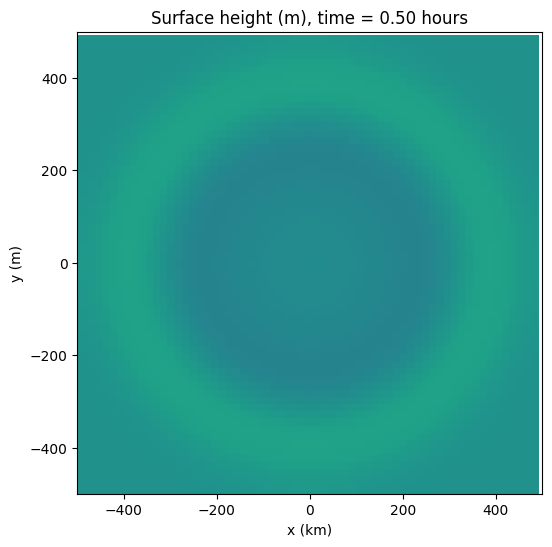

In [9]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:], vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Notice how the amplitude of the Tsunami wave decreases with distance from the source location. In the cell below, make a prediction for how the wave amplitude will vary as a function of distance from the origin (x=0, y=0) using conservation of energy. Then, make a plot or plots comparing your prediction for the wave amplitude compared with the results from the simulation.

Try out several different possible initial conditions for the surface height, $h$. How does the shape of the resulting waves change?

** PREDICTION OF WAVE AMPLITUDE **

Amplitude decays with $\sqrt{r}$, such that $A = A_0/\sqrt{r}$, where $r$ is radius. In the plot above, this is equivalent to distance away from (x,y) = (0,0).

This is derived the following way:

- Intensity = Energy / Area
- 'Area' at a given time is defined as a ring of thickness $w$ and circumference $2\pi r$
- Hence, intensity = energy / $2\pi rw$
- Furthermore, energy is proportional to amplitude squared.
- This can be simplified by allowing $r$ to scale with $w$, producing $A^2 = A_0^2 /r^2$
- We then receive $A = A_0/\sqrt{r}$ as needed.

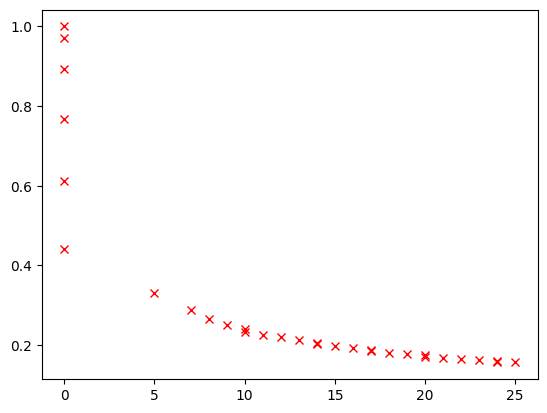

In [21]:
# ADD CODE TO MAKE PLOTS HERE

# This takes a portion of the height data at x=32 and y data after y=32
# This is the RHS portion of the centre line
h_slice = h_save[:,32,32:]

y_max = np.argmax(h_slice,axis=1)

h_max = np.max(h_slice,axis=1)
h_max

plt.plot(y_max,h_max, 'rx')


<ipython-input-11-76bc4d191b48>:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(r, 0.75/abs(np.sqrt(r)), label = 'Best fit')


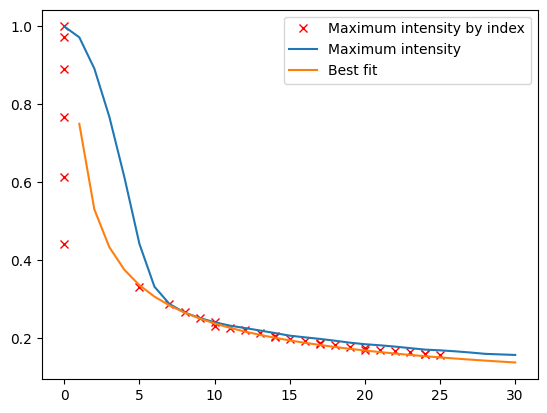

In [11]:
from math import sqrt
r = np.linspace(0,30,31)

plt.plot(y_max,h_max, 'rx', label = 'Maximum intensity by index')
plt.plot(r, h_max, label = 'Maximum intensity')
plt.plot(r, 0.75/abs(np.sqrt(r)), label = 'Best fit')
plt.legend()

The plots above show how intensity of the wave varies with time. We predicted a $1/\sqrt{r}$ relationship, whereby intensity decays as area covered increases.

This is tested through a few representations. First, the red crosses on the above plot show the maximum height values along a cross section at their respective y indices. Visually it is clear that this follows the expected trend of exponential decay. However, this is affected by the fact that the maximum H value remains at the centre (y=0 here) for multiple timesteps, and we therefore see a deformed shape at the start.

This is partially rectified on the blue line above, where I have spaced out points evenly. This produces a smoother curve, however we notice that the centre points still do not follow the expected trend. The centered maximum effect is difficult to work around, clearly. However, after approximately 6 points we see the expected trend.

Finally, I plot a $1/r^2$ relationship. Because I started with a radius of 0, there is no point plotted at $r=0$. Expected initial amplitude has a magnitude of 1, therefore the second point plotted should have amplitude $1/ \sqrt{2}$. However, due to the complex effects at the centre, we see that an quasi-$A_0$ of 0.75 fits the data best. It is clear that the far points follow the expected $1/r^2$ relationship well, therefore supporting my hypothesis.


In [12]:
# trying out different initial conditions

In [40]:
# Import the required packages
# import numpy as np
# import dedalus.public as dedalus
# import logging
# import matplotlib.pyplot as plt

# logger = logging.getLogger(__name__)

# # Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
# second = 1
# minute = 60
# hour = 3600
# day = hour * 24

# # Specify the simulation parameters
# Lx = 1000 * kilometer # The domain size in x
# Ly = 1000 * kilometer # The domain size in y
# Nx = 64 # The number of gridpoints in x
# Ny = 64 # The number of gridpoints in y
# g = 9.81 * meter / second**2 # Gravitational acceleration
# H = 4 * kilometer # Reference ocean depth
# width = 100 * kilometer # Set the width of the initial Gaussian

# timestep = 60 * second # Specify the timestep
# stop_sim_time = 30 * minute # Specify the stopping time

# timestepper = dedalus.RK222
# max_timestep = 0.125

# # Bases
# coords = dedalus.CartesianCoordinates('x', 'y')
# dist = dedalus.Distributor(coords, dtype=np.float64)
# xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
# ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

# x, y = dist.local_grids(xbasis, ybasis)

# # Fields
# u = dist.Field(name='u', bases=(xbasis, ybasis))
# v = dist.Field(name='v', bases=(xbasis, ybasis))
# h = dist.Field(name='h', bases=(xbasis, ybasis))

# HERE
h_factors = [0.5,2,1]
h_data = []

widths = [10*kilometer,50*kilometer,100*kilometer,200*kilometer,500*kilometer]

for i in range(len(h_factors)):
  for j in range(len(widths)):
    factor = h_factors[i]
    current_width = widths[j]

    # Initial conditions
    h.change_scales(1) # Set values on regular grid
    u.change_scales(1)
    v.change_scales(1)
    h['g'] = factor*np.exp(-(x**2+y**2)/current_width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
    u['g'] = 0
    v['g'] = 0

    # Operators
    dx = lambda a: dedalus.Differentiate(a, coords['x'])
    dy = lambda a: dedalus.Differentiate(a, coords['y'])

    # Problem
    problem = dedalus.IVP([u, v, h], namespace=locals())
    problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
    problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
    problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

    # Solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Analysis
    snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
    snapshots.add_task(h, name='h')
    snapshots.add_task(u, name='u')
    snapshots.add_task(v, name='v')

    h.change_scales(1)
    h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 1 == 0:
                h.change_scales(1)
                h_save.append(np.copy(h['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

    #now to save the bit I want
    h_slice = h_save[:,32,32:]
    h_max = np.max(h_slice,axis=1)
    h_data.append(h_max)


INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 4.3e+01/s


2024-11-22 19:28:49,837 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 4.3e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 4.2e+01/s


2024-11-22 19:28:49,908 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 4.2e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 3.9e+01/s


2024-11-22 19:28:50,017 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 3.9e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 2.8e+01/s


2024-11-22 19:28:50,246 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


2024-11-22 19:28:50,384 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.2e+01/s


2024-11-22 19:28:50,439 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.2e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.5e+01/s


2024-11-22 19:28:50,509 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2024-11-22 19:28:50,569 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.9e+01/s


2024-11-22 19:28:50,624 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.9e+01/s


INFO:__main__:Starting main loop


2024-11-22 19:28:50,632 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-22 19:28:51,097 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-11-22 19:28:51,101 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-11-22 19:28:51,106 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.8385 sec


2024-11-22 19:28:51,111 solvers 0/1 INFO :: Setup time (init - iter 0): 0.8385 sec


INFO:solvers:Warmup time (iter 0-10): 0.1746 sec


2024-11-22 19:28:51,114 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1746 sec


INFO:solvers:Run time (iter 10-end): 0.2878 sec


2024-11-22 19:28:51,116 solvers 0/1 INFO :: Run time (iter 10-end): 0.2878 sec


INFO:solvers:CPU time (iter 10-end): 7.994e-05 cpu-hr


2024-11-22 19:28:51,118 solvers 0/1 INFO :: CPU time (iter 10-end): 7.994e-05 cpu-hr


INFO:solvers:Speed: 1.655e+06 mode-stages/cpu-sec


2024-11-22 19:28:51,120 solvers 0/1 INFO :: Speed: 1.655e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 8.1e+01/s


2024-11-22 19:28:51,170 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 8.1e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+01/s


2024-11-22 19:28:51,209 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.9e+01/s


2024-11-22 19:28:51,258 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.9e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+01/s


2024-11-22 19:28:51,310 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+01/s


2024-11-22 19:28:51,362 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 7.5e+01/s


2024-11-22 19:28:51,423 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 7.5e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+01/s


2024-11-22 19:28:51,482 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


2024-11-22 19:28:51,542 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


2024-11-22 19:28:51,598 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


INFO:__main__:Starting main loop


2024-11-22 19:28:51,606 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-22 19:28:52,061 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-11-22 19:28:52,066 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-11-22 19:28:52,070 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.4653 sec


2024-11-22 19:28:52,073 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4653 sec


INFO:solvers:Warmup time (iter 0-10): 0.1844 sec


2024-11-22 19:28:52,078 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1844 sec


INFO:solvers:Run time (iter 10-end): 0.2694 sec


2024-11-22 19:28:52,080 solvers 0/1 INFO :: Run time (iter 10-end): 0.2694 sec


INFO:solvers:CPU time (iter 10-end): 7.484e-05 cpu-hr


2024-11-22 19:28:52,082 solvers 0/1 INFO :: CPU time (iter 10-end): 7.484e-05 cpu-hr


INFO:solvers:Speed: 1.768e+06 mode-stages/cpu-sec


2024-11-22 19:28:52,086 solvers 0/1 INFO :: Speed: 1.768e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 5.7e+01/s


2024-11-22 19:28:52,151 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 5.7e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 5.4e+01/s


2024-11-22 19:28:52,208 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 5.4e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+01/s


2024-11-22 19:28:52,271 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+01/s


2024-11-22 19:28:52,329 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 6.1e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


2024-11-22 19:28:52,384 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


2024-11-22 19:28:52,438 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s


2024-11-22 19:28:52,489 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s


2024-11-22 19:28:52,554 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


2024-11-22 19:28:52,616 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


INFO:__main__:Starting main loop


2024-11-22 19:28:52,625 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-22 19:28:53,086 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-11-22 19:28:53,090 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-11-22 19:28:53,094 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.5191 sec


2024-11-22 19:28:53,097 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5191 sec


INFO:solvers:Warmup time (iter 0-10): 0.1798 sec


2024-11-22 19:28:53,099 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1798 sec


INFO:solvers:Run time (iter 10-end): 0.2742 sec


2024-11-22 19:28:53,101 solvers 0/1 INFO :: Run time (iter 10-end): 0.2742 sec


INFO:solvers:CPU time (iter 10-end): 7.617e-05 cpu-hr


2024-11-22 19:28:53,104 solvers 0/1 INFO :: CPU time (iter 10-end): 7.617e-05 cpu-hr


INFO:solvers:Speed: 1.737e+06 mode-stages/cpu-sec


2024-11-22 19:28:53,106 solvers 0/1 INFO :: Speed: 1.737e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 8.9e+01/s


2024-11-22 19:28:53,152 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 8.9e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+01/s


2024-11-22 19:28:53,193 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.8e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+01/s


2024-11-22 19:28:53,249 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s


2024-11-22 19:28:53,308 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


2024-11-22 19:28:53,360 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


2024-11-22 19:28:53,426 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


2024-11-22 19:28:53,477 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s


2024-11-22 19:28:53,531 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


2024-11-22 19:28:53,600 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


INFO:__main__:Starting main loop


2024-11-22 19:28:53,614 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-22 19:28:54,123 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-11-22 19:28:54,131 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-11-22 19:28:54,136 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.4874 sec


2024-11-22 19:28:54,139 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4874 sec


INFO:solvers:Warmup time (iter 0-10): 0.198 sec


2024-11-22 19:28:54,141 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.198 sec


INFO:solvers:Run time (iter 10-end): 0.3122 sec


2024-11-22 19:28:54,144 solvers 0/1 INFO :: Run time (iter 10-end): 0.3122 sec


INFO:solvers:CPU time (iter 10-end): 8.671e-05 cpu-hr


2024-11-22 19:28:54,148 solvers 0/1 INFO :: CPU time (iter 10-end): 8.671e-05 cpu-hr


INFO:solvers:Speed: 1.526e+06 mode-stages/cpu-sec


2024-11-22 19:28:54,151 solvers 0/1 INFO :: Speed: 1.526e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 6.2e+01/s


2024-11-22 19:28:54,214 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 6.2e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 5.5e+01/s


2024-11-22 19:28:54,271 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 5.5e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+01/s


2024-11-22 19:28:54,327 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


2024-11-22 19:28:54,387 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


2024-11-22 19:28:54,446 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


2024-11-22 19:28:54,509 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


2024-11-22 19:28:54,562 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


2024-11-22 19:28:54,620 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


2024-11-22 19:28:54,695 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


INFO:__main__:Starting main loop


2024-11-22 19:28:54,703 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-22 19:28:55,172 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-11-22 19:28:55,175 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-11-22 19:28:55,179 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.5221 sec


2024-11-22 19:28:55,182 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5221 sec


INFO:solvers:Warmup time (iter 0-10): 0.1832 sec


2024-11-22 19:28:55,184 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1832 sec


INFO:solvers:Run time (iter 10-end): 0.2832 sec


2024-11-22 19:28:55,186 solvers 0/1 INFO :: Run time (iter 10-end): 0.2832 sec


INFO:solvers:CPU time (iter 10-end): 7.867e-05 cpu-hr


2024-11-22 19:28:55,192 solvers 0/1 INFO :: CPU time (iter 10-end): 7.867e-05 cpu-hr


INFO:solvers:Speed: 1.682e+06 mode-stages/cpu-sec


2024-11-22 19:28:55,194 solvers 0/1 INFO :: Speed: 1.682e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 8.3e+01/s


2024-11-22 19:28:55,246 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 8.3e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+01/s


2024-11-22 19:28:55,286 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+01/s


2024-11-22 19:28:55,338 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


2024-11-22 19:28:55,399 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


2024-11-22 19:28:55,454 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


2024-11-22 19:28:55,514 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s


2024-11-22 19:28:55,566 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


2024-11-22 19:28:55,618 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


2024-11-22 19:28:55,682 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


INFO:__main__:Starting main loop


2024-11-22 19:28:55,691 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-22 19:28:56,171 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-11-22 19:28:56,176 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-11-22 19:28:56,183 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.4773 sec


2024-11-22 19:28:56,187 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4773 sec


INFO:solvers:Warmup time (iter 0-10): 0.1812 sec


2024-11-22 19:28:56,190 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1812 sec


INFO:solvers:Run time (iter 10-end): 0.2966 sec


2024-11-22 19:28:56,192 solvers 0/1 INFO :: Run time (iter 10-end): 0.2966 sec


INFO:solvers:CPU time (iter 10-end): 8.24e-05 cpu-hr


2024-11-22 19:28:56,203 solvers 0/1 INFO :: CPU time (iter 10-end): 8.24e-05 cpu-hr


INFO:solvers:Speed: 1.606e+06 mode-stages/cpu-sec


2024-11-22 19:28:56,208 solvers 0/1 INFO :: Speed: 1.606e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


2024-11-22 19:28:56,250 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


2024-11-22 19:28:56,293 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


2024-11-22 19:28:56,351 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s


2024-11-22 19:28:56,415 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


2024-11-22 19:28:56,479 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s


2024-11-22 19:28:56,535 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s


2024-11-22 19:28:56,592 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


2024-11-22 19:28:56,657 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 6.6e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


2024-11-22 19:28:56,730 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.5e+01/s


INFO:__main__:Starting main loop


2024-11-22 19:28:56,737 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-22 19:28:57,205 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-11-22 19:28:57,210 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-11-22 19:28:57,215 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.5172 sec


2024-11-22 19:28:57,217 solvers 0/1 INFO :: Setup time (init - iter 0): 0.5172 sec


INFO:solvers:Warmup time (iter 0-10): 0.1757 sec


2024-11-22 19:28:57,220 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1757 sec


INFO:solvers:Run time (iter 10-end): 0.2887 sec


2024-11-22 19:28:57,222 solvers 0/1 INFO :: Run time (iter 10-end): 0.2887 sec


INFO:solvers:CPU time (iter 10-end): 8.021e-05 cpu-hr


2024-11-22 19:28:57,224 solvers 0/1 INFO :: CPU time (iter 10-end): 8.021e-05 cpu-hr


INFO:solvers:Speed: 1.649e+06 mode-stages/cpu-sec


2024-11-22 19:28:57,226 solvers 0/1 INFO :: Speed: 1.649e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 9.1e+01/s


2024-11-22 19:28:57,279 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 9.1e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+01/s


2024-11-22 19:28:57,319 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.7e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.5e+01/s


2024-11-22 19:28:57,375 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.5e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s


2024-11-22 19:28:57,434 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


2024-11-22 19:28:57,487 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 7.3e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


2024-11-22 19:28:57,549 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


2024-11-22 19:28:57,605 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


2024-11-22 19:28:57,663 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 7.1e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


2024-11-22 19:28:57,725 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


INFO:__main__:Starting main loop


2024-11-22 19:28:57,734 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-22 19:28:58,209 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-11-22 19:28:58,213 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-11-22 19:28:58,217 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.482 sec


2024-11-22 19:28:58,221 solvers 0/1 INFO :: Setup time (init - iter 0): 0.482 sec


INFO:solvers:Warmup time (iter 0-10): 0.1876 sec


2024-11-22 19:28:58,223 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.1876 sec


INFO:solvers:Run time (iter 10-end): 0.2861 sec


2024-11-22 19:28:58,225 solvers 0/1 INFO :: Run time (iter 10-end): 0.2861 sec


INFO:solvers:CPU time (iter 10-end): 7.947e-05 cpu-hr


2024-11-22 19:28:58,227 solvers 0/1 INFO :: CPU time (iter 10-end): 7.947e-05 cpu-hr


INFO:solvers:Speed: 1.665e+06 mode-stages/cpu-sec


2024-11-22 19:28:58,229 solvers 0/1 INFO :: Speed: 1.665e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


2024-11-22 19:28:58,284 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


2024-11-22 19:28:58,326 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+01/s


2024-11-22 19:28:58,376 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s


2024-11-22 19:28:58,435 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 7.2e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+01/s


2024-11-22 19:28:58,766 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2024-11-22 19:28:58,830 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.9e+01/s


2024-11-22 19:28:58,890 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.9e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 4.1e+01/s


2024-11-22 19:28:58,944 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 4.1e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 4.3e+01/s


2024-11-22 19:28:59,006 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 4.3e+01/s


INFO:__main__:Starting main loop


2024-11-22 19:28:59,015 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-22 19:28:59,691 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-11-22 19:28:59,697 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-11-22 19:28:59,704 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.7677 sec


2024-11-22 19:28:59,706 solvers 0/1 INFO :: Setup time (init - iter 0): 0.7677 sec


INFO:solvers:Warmup time (iter 0-10): 0.2523 sec


2024-11-22 19:28:59,708 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.2523 sec


INFO:solvers:Run time (iter 10-end): 0.4224 sec


2024-11-22 19:28:59,710 solvers 0/1 INFO :: Run time (iter 10-end): 0.4224 sec


INFO:solvers:CPU time (iter 10-end): 0.0001173 cpu-hr


2024-11-22 19:28:59,712 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0001173 cpu-hr


INFO:solvers:Speed: 1.128e+06 mode-stages/cpu-sec


2024-11-22 19:28:59,717 solvers 0/1 INFO :: Speed: 1.128e+06 mode-stages/cpu-sec


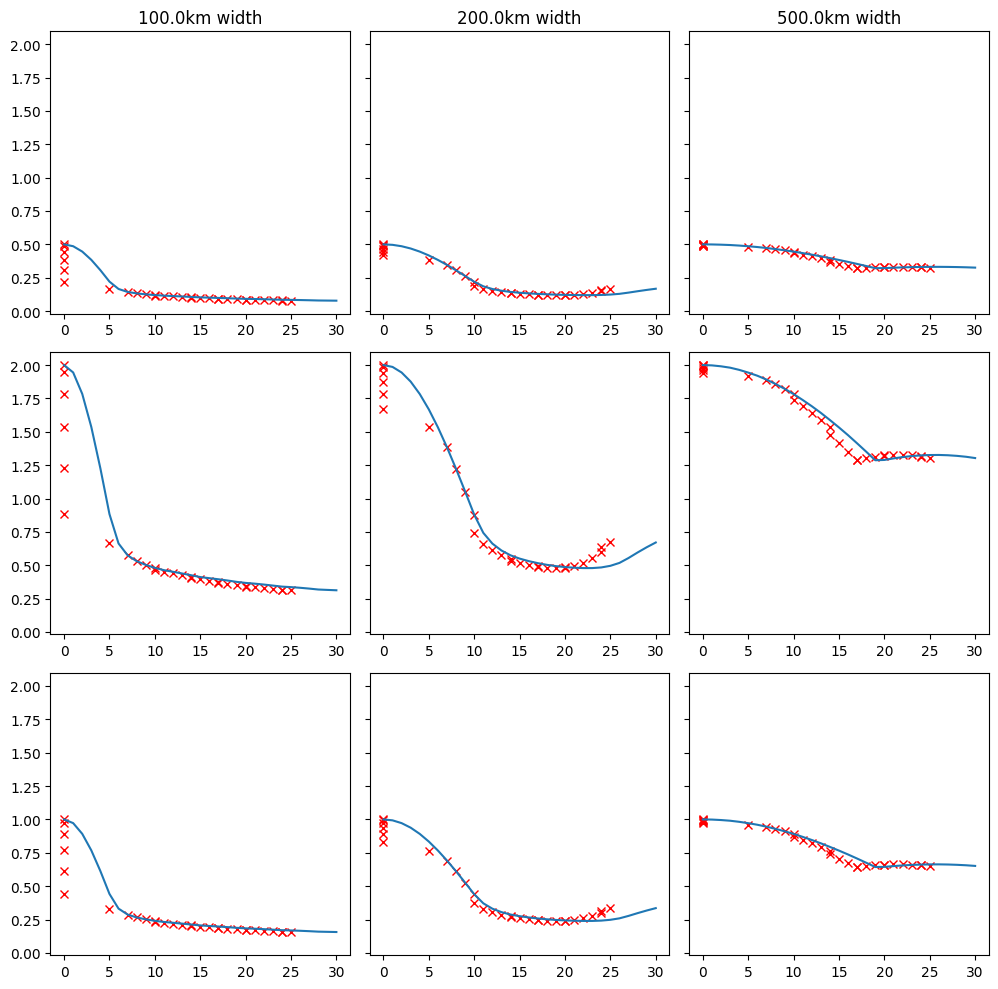

In [41]:
fig, axs = plt.subplots(5, 3, figsize=(15, 9), sharey = True)

for i, ax in enumerate(axs.flatten()):
    #ax.plot(h_data[i])
    #ax.set_title(f'Dataset {i+1}')
    ax.plot(y_max,h_data[i], 'rx', label = '0.5')
    ax.plot(r, h_data[i])

axs[0][0].set_title(f'{widths[0]/1000}km width')
axs[0][1].set_title(f'{widths[1]/1000}km width')
axs[0][2].set_title(f'{widths[2]/1000}km width')
axs[0][3].set_title(f'{widths[3]/1000}km width')
axs[0][4].set_title(f'{widths[4]/1000}km width')


plt.tight_layout()
plt.show()

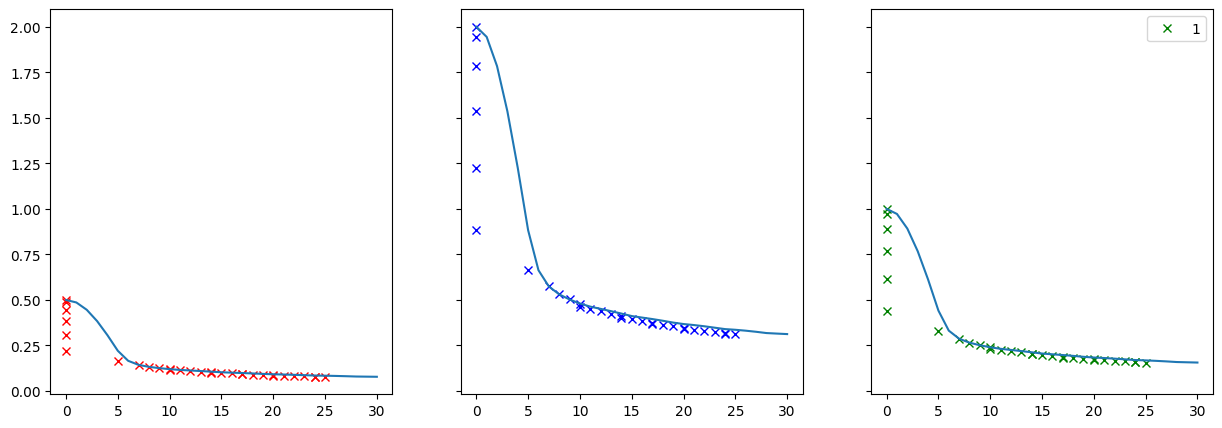

In [39]:
r = np.linspace(0,30,31)

fig, axs = plt.subplots(figsize = (15,5), ncols = 3, sharey = True)

axs[0].plot(y_max,h_data[2], 'rx', label = '0.5')
axs[0].plot(r, h_data[2])

axs[1].plot(y_max,h_data[5], 'bx', label = '2')
axs[1].plot(r, h_data[5])

axs[2].plot(y_max,h_data[8], 'gx', label = '1')
axs[2].plot(r, h_data[8])

plt.legend()
plt.show()

ADD DISCUSSION HERE (~1 paragraph)

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way.

Specifically, we will solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [17]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 4s, Rate: 1.7e+01/s


2024-11-22 19:18:09,500 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 4s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 2.3e+01/s


2024-11-22 19:18:09,753 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 2.3e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 1s, Remaining: 2s, Rate: 2.3e+01/s


2024-11-22 19:18:10,046 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 1s, Remaining: 2s, Rate: 2.3e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 1s, Remaining: 2s, Rate: 2.3e+01/s


2024-11-22 19:18:10,337 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 1s, Remaining: 2s, Rate: 2.3e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 2.3e+01/s


2024-11-22 19:18:10,636 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 2.3e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


2024-11-22 19:18:10,861 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 2s, Remaining: 1s, Rate: 2.6e+01/s


2024-11-22 19:18:11,047 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 2s, Remaining: 1s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 2s, Remaining: 1s, Rate: 2.7e+01/s


2024-11-22 19:18:11,249 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 2s, Remaining: 1s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 2s, Remaining: 0s, Rate: 2.8e+01/s


2024-11-22 19:18:11,425 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 2s, Remaining: 0s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.9e+01/s


2024-11-22 19:18:11,611 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.9e+01/s


INFO:__main__:Starting main loop


2024-11-22 19:18:11,618 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2024-11-22 19:18:15,728 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2024-11-22 19:18:16,508 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2024-11-22 19:18:17,021 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2024-11-22 19:18:17,497 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2024-11-22 19:18:18,002 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2024-11-22 19:18:18,514 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2024-11-22 19:18:18,992 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2024-11-22 19:18:19,459 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2024-11-22 19:18:19,943 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2024-11-22 19:18:20,411 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2024-11-22 19:18:21,405 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2024-11-22 19:18:22,754 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2024-11-22 19:18:24,860 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2024-11-22 19:18:25,687 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2024-11-22 19:18:27,030 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=151, Time=9.060000e+04, dt=6.000000e+02


2024-11-22 19:18:28,042 __main__ 0/1 INFO :: Iteration=151, Time=9.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2024-11-22 19:18:28,549 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=171, Time=1.026000e+05, dt=6.000000e+02


2024-11-22 19:18:29,048 __main__ 0/1 INFO :: Iteration=171, Time=1.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2024-11-22 19:18:29,576 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=191, Time=1.146000e+05, dt=6.000000e+02


2024-11-22 19:18:30,082 __main__ 0/1 INFO :: Iteration=191, Time=1.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2024-11-22 19:18:30,623 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=211, Time=1.266000e+05, dt=6.000000e+02


2024-11-22 19:18:31,157 __main__ 0/1 INFO :: Iteration=211, Time=1.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2024-11-22 19:18:31,686 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=231, Time=1.386000e+05, dt=6.000000e+02


2024-11-22 19:18:32,204 __main__ 0/1 INFO :: Iteration=231, Time=1.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2024-11-22 19:18:32,711 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=251, Time=1.506000e+05, dt=6.000000e+02


2024-11-22 19:18:33,216 __main__ 0/1 INFO :: Iteration=251, Time=1.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2024-11-22 19:18:33,754 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=271, Time=1.626000e+05, dt=6.000000e+02


2024-11-22 19:18:34,270 __main__ 0/1 INFO :: Iteration=271, Time=1.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2024-11-22 19:18:34,842 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=291, Time=1.746000e+05, dt=6.000000e+02


2024-11-22 19:18:35,622 __main__ 0/1 INFO :: Iteration=291, Time=1.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2024-11-22 19:18:36,395 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=311, Time=1.866000e+05, dt=6.000000e+02


2024-11-22 19:18:37,176 __main__ 0/1 INFO :: Iteration=311, Time=1.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2024-11-22 19:18:37,979 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=331, Time=1.986000e+05, dt=6.000000e+02


2024-11-22 19:18:38,572 __main__ 0/1 INFO :: Iteration=331, Time=1.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2024-11-22 19:18:39,051 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=351, Time=2.106000e+05, dt=6.000000e+02


2024-11-22 19:18:39,535 __main__ 0/1 INFO :: Iteration=351, Time=2.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2024-11-22 19:18:40,036 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=371, Time=2.226000e+05, dt=6.000000e+02


2024-11-22 19:18:40,512 __main__ 0/1 INFO :: Iteration=371, Time=2.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2024-11-22 19:18:41,036 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=391, Time=2.346000e+05, dt=6.000000e+02


2024-11-22 19:18:41,497 __main__ 0/1 INFO :: Iteration=391, Time=2.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2024-11-22 19:18:41,998 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=411, Time=2.466000e+05, dt=6.000000e+02


2024-11-22 19:18:42,483 __main__ 0/1 INFO :: Iteration=411, Time=2.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2024-11-22 19:18:42,960 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=431, Time=2.586000e+05, dt=6.000000e+02


2024-11-22 19:18:43,438 __main__ 0/1 INFO :: Iteration=431, Time=2.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2024-11-22 19:18:43,922 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=451, Time=2.706000e+05, dt=6.000000e+02


2024-11-22 19:18:44,398 __main__ 0/1 INFO :: Iteration=451, Time=2.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2024-11-22 19:18:44,877 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


ERROR:__main__:Exception raised, triggering end of main loop.


2024-11-22 19:18:45,335 __main__ 0/1 ERROR :: Exception raised, triggering end of main loop.


INFO:solvers:Final iteration: 470


2024-11-22 19:18:45,340 solvers 0/1 INFO :: Final iteration: 470


INFO:solvers:Final sim time: 282175.73593128804


2024-11-22 19:18:45,345 solvers 0/1 INFO :: Final sim time: 282175.73593128804


INFO:solvers:Setup time (init - iter 0): 5.522 sec


2024-11-22 19:18:45,347 solvers 0/1 INFO :: Setup time (init - iter 0): 5.522 sec


INFO:solvers:Warmup time (iter 0-10): 1.575 sec


2024-11-22 19:18:45,349 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.575 sec


INFO:solvers:Run time (iter 10-end): 28.88 sec


2024-11-22 19:18:45,353 solvers 0/1 INFO :: Run time (iter 10-end): 28.88 sec


INFO:solvers:CPU time (iter 10-end): 0.008021 cpu-hr


2024-11-22 19:18:45,357 solvers 0/1 INFO :: CPU time (iter 10-end): 0.008021 cpu-hr


INFO:solvers:Speed: 3.852e+05 mode-stages/cpu-sec


2024-11-22 19:18:45,360 solvers 0/1 INFO :: Speed: 3.852e+05 mode-stages/cpu-sec


KeyboardInterrupt: 

### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. Notice that as the gravity waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

ADD PLOTS AND DISCUSSION HERE

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the co-latitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves and compare them with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

In [ ]:
# ADD CODE HERE TO SOLVE THE SHALLOW WATER EQUATIONS WITH DAMPING.
# YOU CAN START BY COPYING THE CODE ABOVE AND PASTING IT HERE

## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?